In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "./data/menswear/"
sz=224

In [4]:
print("Cuda available?", torch.cuda.is_available())
print("CUDNN enables?", torch.backends.cudnn.enabled)

Cuda available? True
CUDNN enables? True


In [5]:
os.listdir(PATH)

['tmp', 'models', 'train', 'valid']

In [6]:
os.listdir(f'{PATH}valid')

['kurta',
 'blazer',
 'jackets',
 'formal-shirt',
 'round-t',
 'polo-t',
 'casual-shirt']

In [7]:
files = os.listdir(f'{PATH}valid/polo-t')[:5]
files

['11487587875138-John-Players-Men-Orange-Solid-Polo-Collar-T-Shirt-3331487587874888-1_mini.jpeg',
 '2018-04-27-10-22-30-JTGGFTB1.jpeg',
 '11484640759588-Roadster-Men-Charcoal-Solid-Polo-Collar-T-Shirt-721484640759297-1_mini.jpeg',
 '11469445546517-Nike-Blue-Polyester-Polo-T-shirt-5011469445546302-1_mini.jpeg',
 '11474714836510-American-Crew-Men-Black-Striped-Polo-Collar-T-Shirt-641474714836311-1_mini.jpeg']

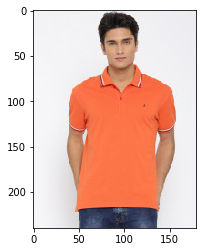

In [8]:
img = plt.imread(f'{PATH}valid/polo-t/{files[0]}')
plt.imshow(img);

In [9]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [10]:
arch=resnet50
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [11]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [12]:
ims = np.stack([get_augs() for i in range(6)])

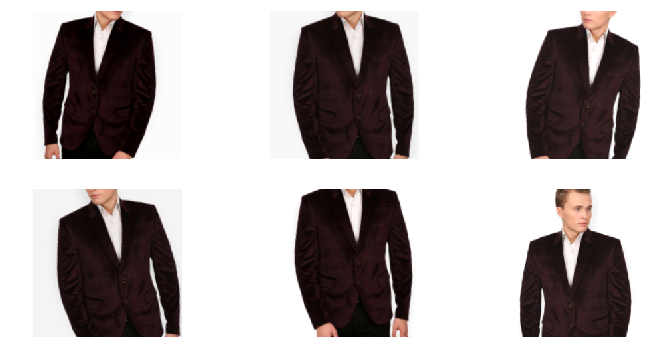

In [13]:
plots(ims, rows=2)

In [14]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [15]:
data.classes

['blazer',
 'casual-shirt',
 'formal-shirt',
 'jackets',
 'kurta',
 'polo-t',
 'round-t']

In [16]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                    
    0      0.428351   0.352799   0.881429  
    1      0.324186   0.318276   0.895714                    
    2      0.293128   0.305497   0.901429                    



[array([0.3055]), 0.9014285734721592]

In [17]:
learn.precompute=False

In [18]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.352886   0.291203   0.895714  
    1      0.343707   0.282733   0.908571                    
    2      0.323802   0.290434   0.908571                    



[array([0.29043]), 0.9085714299338205]

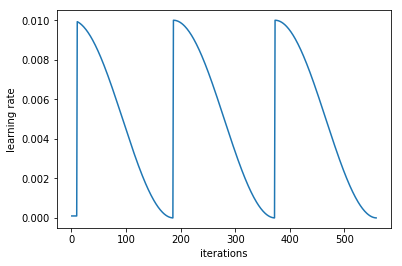

In [19]:
learn.sched.plot_lr()

In [20]:
learn.save('224_lastlayer')

In [21]:
learn.load('224_lastlayer')

In [22]:
learn.unfreeze()

In [23]:
lr=np.array([1e-4,1e-3,1e-2])

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.356926   0.22056    0.925714  
    1      0.234545   0.180305   0.941429                    
    2      0.187982   0.163149   0.944286                    
    3      0.180952   0.166134   0.941429                    
    4      0.152332   0.149165   0.945714                    
    5      0.117537   0.148195   0.947143                    
    6      0.109395   0.152906   0.951429                    



[array([0.15291]), 0.9514285727909633]

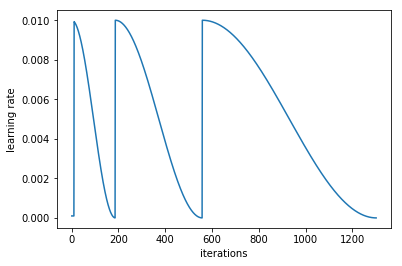

In [25]:
learn.sched.plot_lr()

In [26]:
learn.save('224_all')

In [27]:
learn.load('224_all')

In [28]:
# tfms_t, tfms_v = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# im = tfms_v(open_image('data/menswear/valid/blazer/11497870382026-Wintage-Men-Blazers-4051497870380991-1_mini.jpeg'))
# plt.imshow(plt.imread('data/menswear/valid/blazer/11497870382026-Wintage-Men-Blazers-4051497870380991-1_mini.jpeg'))

# log_preds_single = learn.predict_array(im[None])
# probs_single = np.exp(log_preds_single)
# probs_single

# preds_single = np.argmax(probs_single, axis=1)
# preds_single
# data.classes[preds_single[0]]

In [29]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [30]:
preds = np.argmax(probs, axis=1)

In [31]:
np.sum(preds==y) / 700

0.9514285714285714

In [32]:
accuracy_np(probs, y)

0.9514285714285714

[[98  0  0  2  0  0  0]
 [ 0 93  6  0  0  1  0]
 [ 0  4 96  0  0  0  0]
 [ 2  3  1 92  1  1  0]
 [ 0  4  0  0 96  0  0]
 [ 0  1  0  1  2 95  1]
 [ 0  0  0  0  1  3 96]]


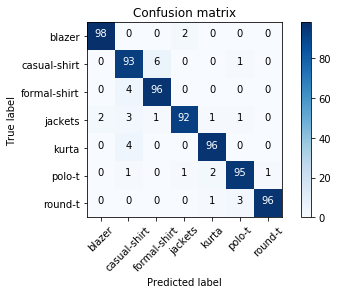

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [77]:
class_idx = 0

samples = np.where(y==class_idx)[0]
y_new = y[samples]
preds_new = preds[samples]
misclassified_samples = np.where(y_new!=preds_new)[0]
print(misclassified_samples)

[76 92]


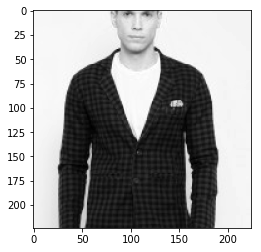

In [80]:
plt.imshow(data.val_ds.get1item(76)[0][0], cmap='gray')